# **Facial Emotion Classifier**

In [1]:
# Basic Python Packages
import os
import random
import time
import pickle

# Numpy Library
import numpy as np

# Pandas Library and Settings
import pandas as pd

# Visualization Libraries (Matplotlib, Seaborn)
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn Libarary
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

# Tensorflow Library
import tensorflow as tf
    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model, to_categorical
from keras.metrics.accuracy_metrics import Accuracy, CategoricalAccuracy
from tensorflow.keras.models import load_model

# OpenCV
import cv2

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus:
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [3]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0,1"

session = tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.set_session(session)

In [5]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
data_directory = "/kaggle/input/fer2013"

print(f"{os.listdir(data_directory)}")

['test', 'train']


In [7]:
train_directory = os.path.join(data_directory, "train")
test_directory = os.path.join(data_directory, "test")

print(f"Data directory     {data_directory}")
print(f"Train directory    {train_directory}")
print(f"Test directory     {test_directory}")

Data directory     /kaggle/input/fer2013
Train directory    /kaggle/input/fer2013/train
Test directory     /kaggle/input/fer2013/test


In [8]:
print(f"{os.listdir(train_directory)}")
print(f"{os.listdir(test_directory)}")

['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


In [12]:
expressions_list = os.listdir(train_directory)

In [13]:
train_dataset_info_df = pd.DataFrame(columns=["Expression", "Size", "Proportion %"])
train_expression_size = []

for expression in expressions_list:
    
    index = expressions_list.index(expression)
    
    train_expression_directory = os.path.join(train_directory, expression)
    train_expression_size.append(len(os.listdir(train_expression_directory)))
    
train_expression_proportion = [round((expression_size / sum(train_expression_size)) * 100, 2)\
                               for expression_size in train_expression_size]

train_dataset_info_df["Expression"] = expressions_list
train_dataset_info_df["Size"] = train_expression_size
train_dataset_info_df["Proportion %"] = train_expression_proportion

total_size = train_dataset_info_df["Size"].sum()
total_proportion = train_dataset_info_df["Proportion %"].sum()

total_row = pd.DataFrame({"Expression": ["Total"],
                          "Size": [total_size],
                          "Proportion %": [total_proportion]})

train_dataset_info_df = pd.concat([train_dataset_info_df, total_row], ignore_index=True)

train_dataset_info_df = train_dataset_info_df.style
train_dataset_info_df = train_dataset_info_df.apply(lambda x: ['background-color: green' if\
                                                    i == len(x)-1 else ''\
                                                    for i in range(len(x))], axis=0)

train_dataset_info_df

,Expression,Size,Proportion %
0,surprise,3171,11.050000
1,fear,4097,14.270000
2,angry,3995,13.920000
3,neutral,4965,17.290000
4,sad,4830,16.820000
5,disgust,436,1.520000
6,happy,7215,25.130000
7,Total,28709,100.000000


In [14]:
test_dataset_info_df = pd.DataFrame(columns=["Expression", "Size", "Proportion %"])
test_expression_size = []

for expression in expressions_list:
    
    index = expressions_list.index(expression)
    
    test_expression_directory = os.path.join(test_directory, expression)
    test_expression_size.append(len(os.listdir(test_expression_directory)))
    
test_expression_proportion = [round((expression_size / sum(test_expression_size)) * 100, 2)\
                              for expression_size in test_expression_size]

test_dataset_info_df["Expression"] = expressions_list
test_dataset_info_df["Size"] = test_expression_size
test_dataset_info_df["Proportion %"] = test_expression_proportion

total_size = test_dataset_info_df["Size"].sum()
total_proportion = test_dataset_info_df["Proportion %"].sum()

total_row = pd.DataFrame({"Expression": ["Total"],
                          "Size": [total_size],
                          "Proportion %": [total_proportion]})

test_dataset_info_df = pd.concat([test_dataset_info_df, total_row], ignore_index=True)

test_dataset_info_df = test_dataset_info_df.style
test_dataset_info_df = test_dataset_info_df.apply(lambda x: ['background-color: green'\
                                                  if i == len(x)-1 else ''\
                                                  for i in range(len(x))], axis=0)

test_dataset_info_df

,Expression,Size,Proportion %
0,surprise,831,11.580000
1,fear,1024,14.270000
2,angry,958,13.350000
3,neutral,1233,17.180000
4,sad,1247,17.370000
5,disgust,111,1.550000
6,happy,1774,24.710000
7,Total,7178,100.010000


Let's check one image for each expression to get better understanding of the dataset.

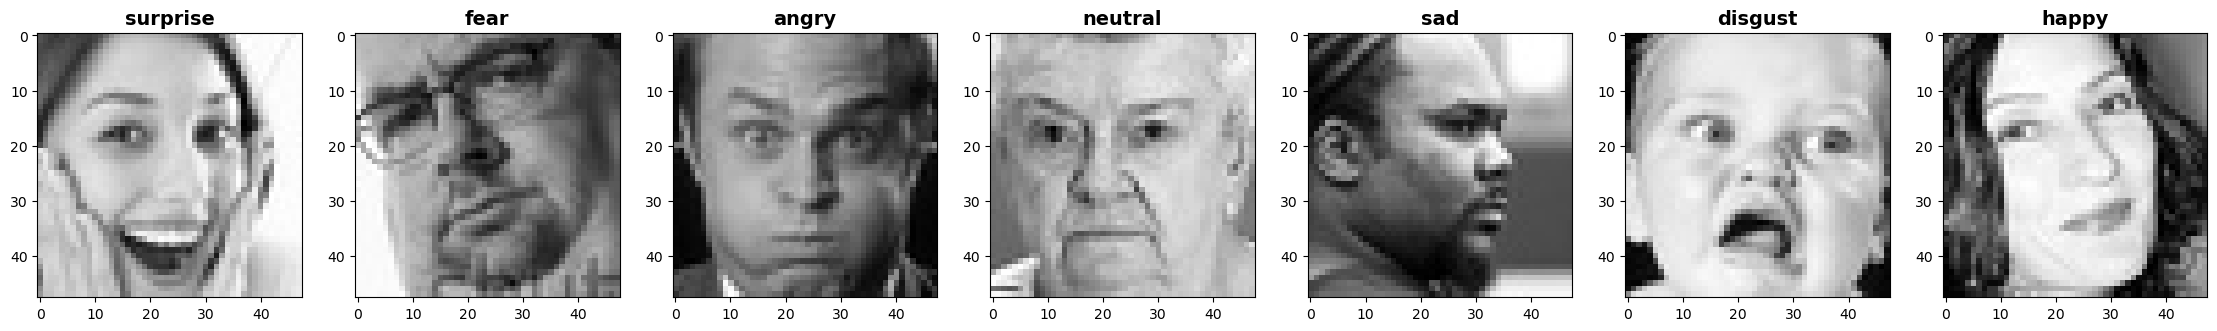

In [17]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}

fig, axes = plt.subplots(1, len(expressions_list), figsize=(len(expressions_list) * 4, 4))

i = 0

while i < len(expressions_list):
    
    expression = expressions_list[i]

    expression_directory = os.path.join(train_directory, expression)
    images_list = os.listdir(expression_directory)
    
    image_directory = os.path.join(expression_directory, random.choice(images_list))
    
    image = cv2.imread(image_directory, cv2.IMREAD_GRAYSCALE)
        
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(expression, fontdict=title_font)
    
    i += 1

plt.show()

In [18]:
print(f"Images shape is: {image.shape}")

Images shape is: (48, 48)


Check if all formats are the same

In [19]:
formats = []

for dir in [train_directory, test_directory]:

    i = 0

    print(f"Checking {dir.split('/')[1]} data:")
    
    while i < len(expressions_list):
        
        expression = expressions_list[i]

        expression_directory = os.path.join(dir, expression)
        images_list = os.listdir(expression_directory)
        
        for image in images_list:
                    
            format = image.split(".")[1]
            
            if format not in formats:
                formats.append(format)

        print(f"    {expression} Checked.")
        
        i += 1

print("-"*30)
print(f"File formats are: {formats}")

Checking kaggle data:
    surprise Checked.
    fear Checked.
    angry Checked.
    neutral Checked.
    sad Checked.
    disgust Checked.
    happy Checked.
Checking kaggle data:
    surprise Checked.
    fear Checked.
    angry Checked.
    neutral Checked.
    sad Checked.
    disgust Checked.
    happy Checked.
------------------------------
File formats are: ['jpg']


In [20]:
data = tf.keras.preprocessing.image_dataset_from_directory(train_directory,
                                                           image_size=(48, 48),
                                                           batch_size=64,
                                                           color_mode="grayscale")

print(f"Data type is:       {type(data)}")

Found 28709 files belonging to 7 classes.
Data type is:       <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [21]:
expressions_list = data.class_names

expressions_list

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In order to use the data, we should iterate over it using the numpy iterator.

In [22]:
data_iterator = data.as_numpy_iterator()

data_iterator

To use this iterated data, we have to get batch from it to feed the neural network.</br>
This step will be completed in the training stage.

In [23]:
batch = data_iterator.next()

print(f"Each batch has {len(batch)} parts of data.")
print(f"Each batch's images part has the shape of {batch[0].shape}")
print(f"Each batch's images part has the shape of {batch[1].shape}")

Each batch has 2 parts of data.
Each batch's images part has the shape of (64, 48, 48, 1)
Each batch's images part has the shape of (64,)


This means that each batch has two parts of data, images and labels.</br>
Images part has 32 images which are 

Before going further, let's check the train dataset by their labels.

Facial expressions are:
    0. angry
    1. disgust
    2. fear
    3. happy
    4. neutral
    5. sad
    6. surprise


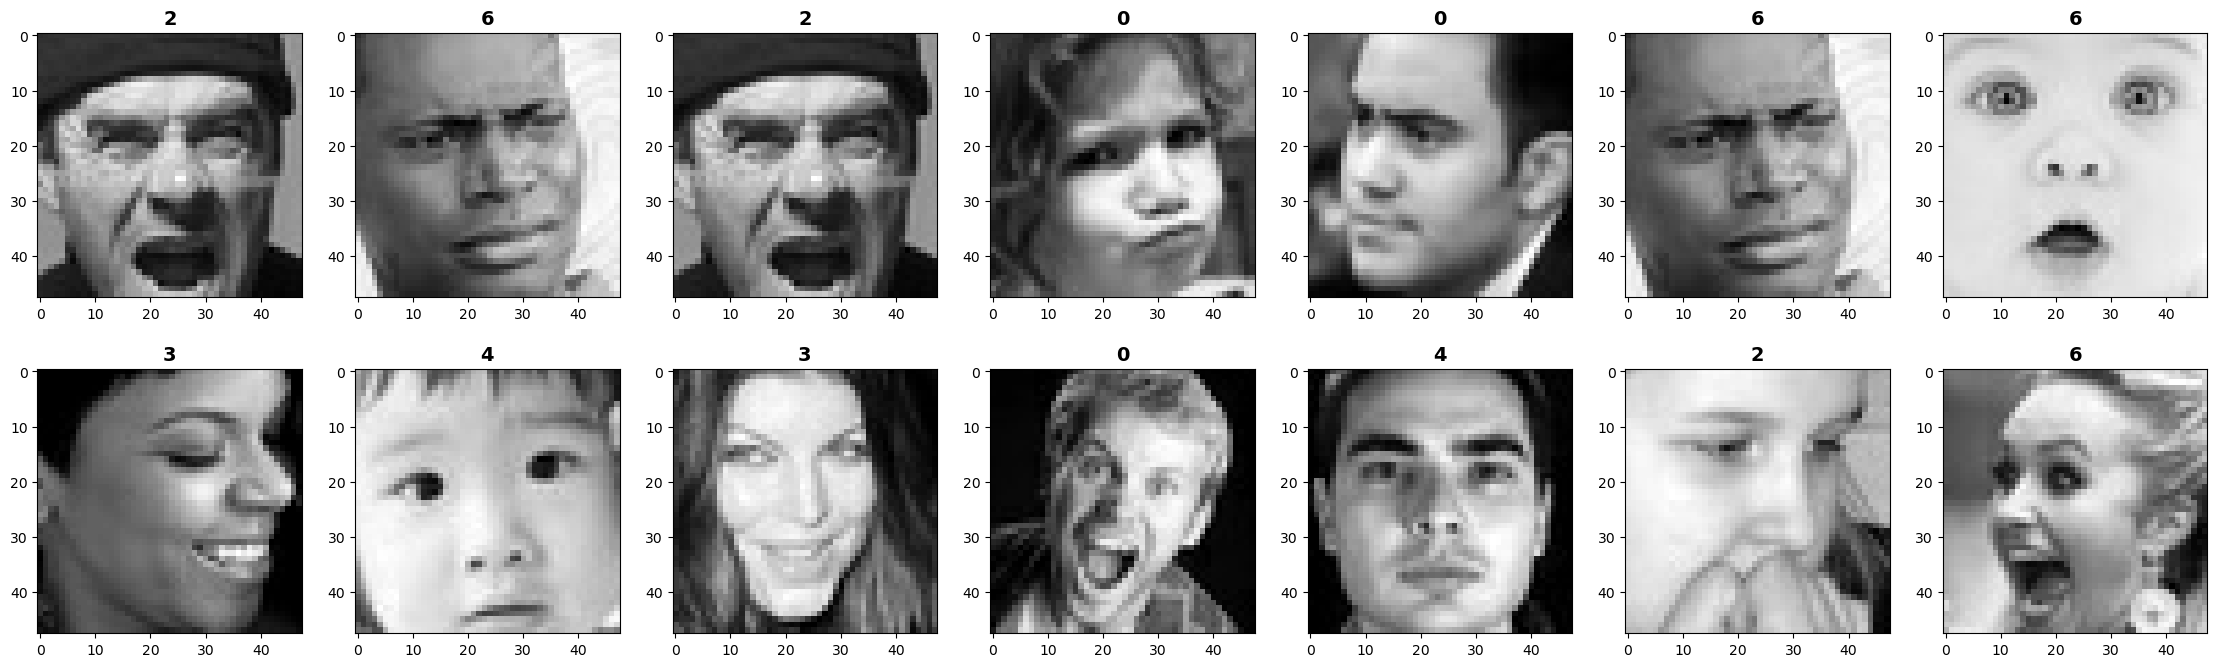

In [24]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}

print("Facial expressions are:")

for expression in expressions_list:
    print(f"    {expressions_list.index(expression)}. {expression}")

indexes = np.random.randint(0, batch[0].shape[0], 14)

fig, axes = plt.subplots(2, 7, figsize=(28, 8))

i = 0
j = 0

for index in indexes:
    
    axes[i, j].imshow(batch[0][index].astype(int), cmap="gray")
    axes[i, j].set_title(batch[1][index], fontdict=title_font)

    j += 1
    
    if j==7:
        i = 1
        j = 0
        
plt.show()

In [ ]:
print(f"Data Minimum: {batch[0].min()}")
print(f"Data Maximum: {batch[0].max()}")

Like most of the times the range of values is between 0 and 255.</br>
Now we can scale the data by deviding its values by 255 to make the learning process faster.

We can do this by using the map function in data pipeline.

In [25]:
data = data.map(lambda x, y: (x/255., y))

Now, we've created the data scaler and the scaler is now embedded in the data pypeline.

Let's check the next batch.

In [26]:
batch = data.as_numpy_iterator().next()

print(f"Data Minimum: {batch[0].min()}")
print(f"Data Maximum: {batch[0].max()}")

Data Minimum: 0.0
Data Maximum: 1.0


As we know, this won't make any change in the images appearance.

In [27]:
train_size = int(len(data)*0.875)
validation_size = int(len(data)*0.125)

print(f"The train dataset size will be {train_size}.")
print(f"The validation dataset size will be {validation_size}.")

The train dataset size will be 392.
The validation dataset size will be 56.


In [29]:
train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)

In [30]:
def get_compiled_model(input_shape, optimizer, loss, metrics):
    """
    This is a Python function that compiles and returns a neural network model using the Keras library.

    Args:
        input_shape (tuple)             The shape of the input data for the model.
        optimizer (str or callable)     The optimizer to use for training the model.
        loss (str or callable)          The loss function to use during training.
        metrics (list)                  The list of evaluation metrics for the model.

    Returns:
        model ()                        The compiled Keras model object that can be used for training.
    """
        
    model = Sequential()
    
    # Convolutional and pooling layers
    
    model.add(Conv2D(32, (3, 3), strides=1, activation="relu",
                     padding="same", input_shape=(48, 48, 1)))
    
    model.add(Conv2D(64, (3, 3), strides=1, activation="relu",
                     padding="same"))

    model.add(BatchNormalization())
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25))

    # Convolutional and pooling layers
    
    model.add(Conv2D(128, (3, 3), strides=1, activation="relu",
                     padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    
    model.add(Conv2D(256, (3, 3), strides=1, activation="relu",
                     padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    
    model.add(BatchNormalization())
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25))

    # Flatten and dense layer
    
    model.add(Flatten())
    
    model.add(Dense(256, activation="relu"))
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.25))
    
    # Flatten and dense layer
    
    model.add(Dense(512, activation="relu"))
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.25))
    
    # Final layer
    
    model.add(Dense(7, activation="softmax"))
    
    # Compiler
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [31]:
def train_model(model, train_data, epochs, validation_data, callbacks):
    """
    Summary:
    This is a Python function that trains a given neural network model
    on the provided training data and returns the training history.

    Args:
        model (tensorflow.keras model)          The neural network model object to train.
        train_data (numpy.ndarray)              The training data to use for training the model.
        train_target (numpy.ndarray)            The target values for the training data.
        epochs (int)                            The number of epochs to train the model.
        validation_data (numpy.ndarray)         The validation data to use for evaluation.
        callbacks (list)                        A list of Keras callbacks to use during training.

    Returns:
        history ()                              The training history object that contains information
                                                about the training and validation metrics over each epoch.
    """

    history = model.fit(train_data,
                        epochs=epochs,
                        validation_data=validation_data,
                        callbacks=callbacks,
                        verbose=1)
    
    return history

In [32]:
class TrainingCallbacks(Callback):
    
    def __init__(self):
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        print("Starting training ...")

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        print(f"Epoch {epoch + 1} completed in {elapsed_time:.2f} seconds")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        print(f"Training finished in {total_time:.2f} seconds")
        
logs_cb = callbacks.TensorBoard(log_dir="logs")

checkpoint = callbacks.ModelCheckpoint(filepath=os.path.join("checkpoints", "model.h5"),
                                       save_best_only=True,
                                       monitor="val_accuracy")
        
callbacks_list = [TrainingCallbacks(), logs_cb, checkpoint]

By using the function above, now we can builld the architecture defined in the function and parameters determined as the arguments.

In [33]:
model = get_compiled_model((48, 48, 1),
                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                           loss="sparse_categorical_crossentropy",
                           metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

It's better to plot the architecture to understand the network better.

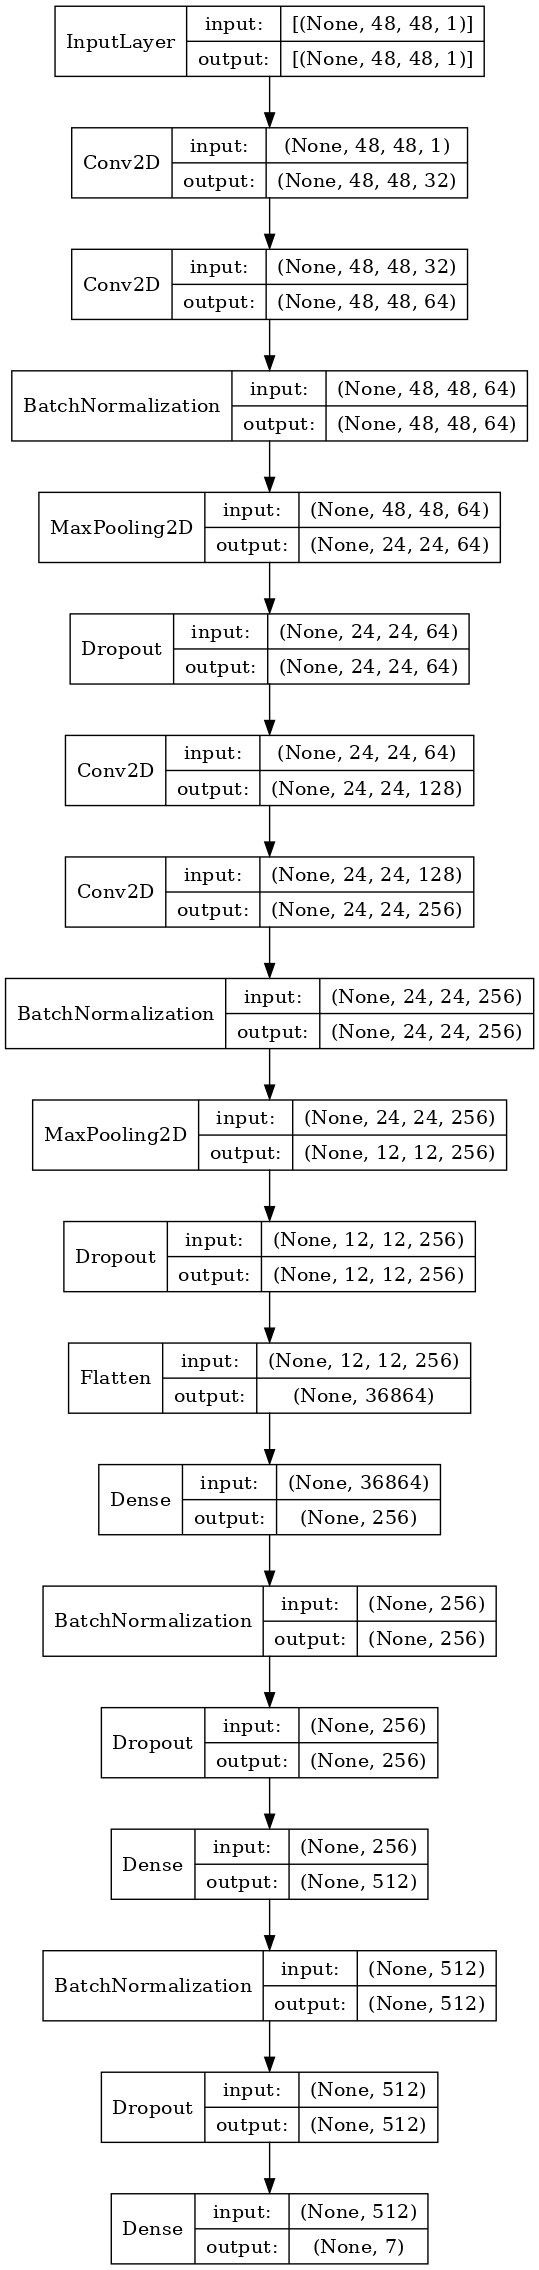

In [34]:
plot_model(model, show_shapes=True,
           show_layer_names=False,
           expand_nested=True,
           rankdir="TB",
           dpi=100)

In [ ]:
history = train_model(model,
                      train_data=train,
                      epochs=60,
                      validation_data=validation,
                      callbacks=callbacks_list)

Starting training ...
Epoch 1/60


2023-09-04 18:11:17.567508: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


392/392 [==============================] - 108s 226ms/step - loss: 4.5399 - accuracy: 0.2686 - val_loss: 9.4797 - val_accuracy: 0.0469
Epoch 2/60
392/392 [==============================] - 38s 96ms/step - loss: 3.8506 - accuracy: 0.3605 - val_loss: 3.6678 - val_accuracy: 0.3697
Epoch 3/60
392/392 [==============================] - 39s 99ms/step - loss: 3.3645 - accuracy: 0.4104 - val_loss: 3.2081 - val_accuracy: 0.4023
Epoch 4/60
392/392 [==============================] - 39s 99ms/step - loss: 2.9984 - accuracy: 0.4469 - val_loss: 2.7252 - val_accuracy: 0.4925
Epoch 5/60
392/392 [==============================] - 39s 98ms/step - loss: 2.6484 - accuracy: 0.4882 - val_loss: 2.5270 - val_accuracy: 0.4936
Epoch 6/60
392/392 [==============================] - 39s 98ms/step - loss: 2.3735 - accuracy: 0.5204 - val_loss: 2.3209 - val_accuracy: 0.5243
Epoch 7/60
392/392 [==============================] - 39s 99ms/step - loss: 2.1341 - accuracy: 0.5572 - val_loss: 2.1122 - val_accuracy: 0.5441
E

In [ ]:
# The model's history can be saved using this block of code.

"""with open(os.path.join("history", "history.pkl"), "wb") as f:
    pickle.dump(history.history, f)"""

In [ ]:
# The model can be loaded and the model's history can be read using this block of code.


"""model = load_model(os.path.join("checkpoints", "model.h5"))

with open(os.path.join("history", "history.pkl"), "rb") as f:
    history = pickle.load(f)"""

history = history.history

In [ ]:
history_df = pd.DataFrame(history)

history_df

Let's check how the model performs in both training and validation datasets through epochs.

In [ ]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
axes_font = {"family" : "arial", "color" : "#023553", "weight" : "bold", "size" : 12}

fig = plt.figure(figsize=(25, 8))

plt.plot(history["loss"], color="#3BB47E", label="Training loss")
plt.plot(history["val_loss"], color="#FF605C", label="Validation Loss")

plt.xticks(range(len(history["loss"])))

plt.legend(loc="upper right")

plt.title("Loss vs Epochs", fontdict = title_font)
plt.xlabel("Epoch Number", fontdict = axes_font)
plt.ylabel("Loss", fontdict = axes_font)

plt.grid(True, axis="x", alpha=0.5, linestyle="--")

max_val_acc_row_index = history_df[history_df["val_accuracy"] == max(history_df["val_accuracy"])].index[-1]

plt.scatter(max_val_acc_row_index,
            history_df.loc[max_val_acc_row_index, "val_loss"])

plt.show()

It's obvious that model suffers from overfitting problem.</br>
This can be the result of many issues, which will be addressed later in this notebook.

We can also check its loss values.

In [ ]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
axes_font = {"family" : "arial", "color" : "#023553", "weight" : "bold", "size" : 12}

fig = plt.figure(figsize=(25, 8))

plt.plot(history["accuracy"], color="#3BB47E", label="Training accuracy")
plt.plot(history["val_accuracy"], color="#FF605C", label="Validation accuracy")

plt.xticks(range(len(history["accuracy"])))

plt.legend(loc="upper left")

plt.title("Accuracy vs Epochs", fontdict = title_font)
plt.xlabel("Epoch Number", fontdict = axes_font)
plt.ylabel("Accuracy", fontdict = axes_font)

plt.grid(True, axis="x", alpha=0.5, linestyle="--")

plt.scatter(max_val_acc_row_index,
            history_df.loc[max_val_acc_row_index, "val_accuracy"])

plt.show()

In [ ]:
print("Testing Results")
print("-"*30)

print(f"Accuracy               {(accuracy.result()*100):.4f}")
print(f"Categorical Accuracy   {(categorical_accuracy.result()*100):.4f}")

Let's check the confusion matrix to understand how the model performed the predictions.

In [ ]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
axes_font = {"family" : "arial", "color" : "#023553", "weight" : "bold", "size" : 12}

normalized_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(normalized_confusion_matrix, annot=True, fmt=".2f", cmap="Blues")

ax.set_xlabel("Predicted Labels", fontdict=axes_font)
ax.set_ylabel("True Labels", fontdict=axes_font)
ax.set_title("Confusion Matrix", fontdict=title_font)

ax.xaxis.set_ticklabels(expressions_list)
ax.yaxis.set_ticklabels(expressions_list)

plt.xticks(rotation=45)

plt.show()